## Notebook to work with interaction dataset merge scenario `DR_CHN_Merging_ZS`
    - Roadway generation
    - Trajdata creation based on reading vehicle tracks from provided csv files

## Changelog
- Friday, Jan 31
    - Creation
    - Toy track generation using way if 10025 from `DR_CHN_Merging_ZS.osm`
- Monday, Feb 3
    - Begin trajdata creation to read in the vehicle tracks. Creation of struct called `INTERACTIONTrajdata`
- Tuesday, Feb 4
    - `Trajdata` reading nominally works. And rendered a scene of course without roadway. Some caveats
        - `car_df_index` line 21 onwards check is commented out
        - No `roadway` involved in the creation of `RecordState`
    - Made a video of replaying the trajdata, of course without roadway, just cars in the blackness
- Wednesday, Feb 5
    - roadway building using `generate_merging_roadway` from `AutonomousMerging.jl`
    - brought in `curevept_overlay` to do overlay the curve points that constitute a road
    - Drove a car in the merging scenario to check that lane semantics works i.e. vehicle understands
    how to keep lane
    - second roadway inspired by William Brannon curved merging lane
- Friday, Feb 7
    - Started pipeline to read Soyeon's centerline data files
    - Generated video replaying interaction dataset on roadways
- Monday, Feb 10
    - Cleanup to prepare for commit to `sisl/AutomotiveInteraction`
- Wednesday, Feb 12
    - Found that the vehicle state needs to have roadway information. Otherwise `observe!` in MOBIL cries
    - This means that we can't initialize the vehicle state the way we have done so far i.e. 
    without providing a `roadway` argument
    - Need to understand `lanes` and `lanetags` and modify roadway creation in terms of how tracks read from
    centerlines txt files into the roadway object
- Friday, Feb 14
    - Got `proj` to work by making `roadway_interaction` in such a way that there are 7 segments, and each segment has only 1 lane. Thus during lane creation, the associated lanetag has `LaneTag(segment_id,1)` as opposed to earlier when the second argument of the LaneTag was going from 1 to 7
- Monday, Feb 17
    - Reorder notebook: make roadway before loading track information
    - function to create the roadway from centerlines called `make_roadway_interaction()` moved to
    `../src/roadway_building.jl`
    - function to read in the vehicle tracks called `read_veh_tracks()` moved to
    `../src/veh_track_reading.jl`
    - Overlayed the vehicle id numbers on the rendered scene using `IDOverlay()`
    - Driven vehicle id 29 using 2D Driver model. Gets stuck at the merge point because lane has
    ended there. Need to fix this
    - Made a new file within `src` called `driving_simulation.jl` to provide simulation functions.
    Moved `get_hallucination_scenes` and `make_def_models` and `run_a_vehicle` into there
    - Roadway recreation for enabling connection at merge point to make vehicle aware of lane
        - Decided that start to end points ordering in txt file should be in direction of travel
        - Separated main lane into until merge point, and after merge point
        - Format of file is now 2 colums with x in col 1 and y in col2. Written using
        `writedlm("filename",coods,',')`
        - 0 has become a, 1 has split into b and then c (direction of travel so b comes first)
        - 2 has become d, 3 has become e

In [1]:
# usings
using AutomotiveDrivingModels # Driving simulation platform
using AutoViz # Visualization of roadways and vehicles
using DataFrames # For reading in vehicle tracks into specific type `Trajdata`
using Records # Storing the vehicle tracks in a format that can then be used by `AutomotiveDrivingModels`
using Reel # Make animations of scene visualizations created using `AutoViz`
using DelimitedFiles # Read in centerline txt files into arrays

In [60]:
# Bring functions into notebook: names are self explanatory
include("../src/roadway_building.jl")
include("../src/veh_track_reading.jl")
include("../src/visualization.jl");
include("../src/driving_simulation.jl")

get_hallucination_scenes

## Build the roadway
- Read centerlines provided in `../dataset`
- functions used (from `AutomotiveInteraction/src/roadway_building.jl)
    - `centerlines_txt2tracks(filename)`, `make_roadway_interaction()`

In [4]:
roadway_interaction = make_roadway_interaction();

## Read vehicle tracks from csv file
- Read vehicle track information provided in `../dataset`
- Functions used (from `AutomotiveInteraction/src/veh_track_reading.jl`)
    - `nframes`, `carsinframe`, `car_df_index`, `read_veh_tracks()`

In [8]:
traj_interaction = read_veh_tracks()

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


Trajdata(3512 frames)

## Driving simulation experiments

In [37]:
scene_list = get_hallucination_scenes(scene_test,models=models,duration=6);

## Understand curveindex_end

In [41]:
    merge_point = VecE2(0.0, 0.0) 
main_lane_length = 20.;main_lane_angle = 0.;n_pts=2
    main_lane_startpt = merge_point + polar(main_lane_length, -float(pi) - main_lane_angle)
    main_curve = gen_straight_curve(main_lane_startpt, merge_point, n_pts)
    merge_index = curveindex_end(main_curve)

CurveIndex(1, 1.000)

In [45]:
main_curve[merge_index]

CurvePt({0.000, 0.000, 0.000}, 20.000, 0.000, NaN)

## Make roadway_interaction to understand merging

In [120]:
# function: centerlines_txt2tracks_new
function centerlines_txt2tracks_new(filename)
    coods = readdlm(filename,',')
    coods_app = append_headings(coods) # Append with the angle
    
    mid_coods = coods_app'
    
    first_cood = VecSE2(mid_coods[1,1], mid_coods[2,1], mid_coods[3,1])
    second_cood = VecSE2(mid_coods[1,2], mid_coods[2,2], mid_coods[3,2])
    radius = 0.01
    nsamples = 20

    track = gen_bezier_curve(first_cood, second_cood, radius, radius, nsamples)
    
    nsamples = 20
    for i = 3:size(coods,1)
        turn1 = VecSE2(mid_coods[1, i-1], mid_coods[2, i-1], mid_coods[3, i-1])
        turn2 = VecSE2(mid_coods[1, i], mid_coods[2, i], mid_coods[3, i])
        curve = gen_bezier_curve(turn1, turn2, radius, radius, nsamples)
        append_to_curve!(track, curve)
    end

    return track
end

centerlines_txt2tracks_new (generic function with 1 method)

In [124]:
track_a = centerlines_txt2tracks_new("test_a.txt"); # Top most on ramp
track_b = centerlines_txt2tracks_new("test_b.txt")
track_c = centerlines_txt2tracks_new("test_c.txt")
merge_index = curveindex_end(track_b)
append_to_curve!(track_b,track_c)
lane1 = Lane(LaneTag(2,1),track_b)
lane0 = Lane(LaneTag(1,1),track_a,next=RoadIndex(merge_index,LaneTag(2,1)))

Lane{Float64}(LaneTag(1, 1), CurvePt{Float64}[CurvePt({1146.270, 973.136, -2.940}, 0.000, 0.000, NaN), CurvePt({1146.236, 973.129, -2.940}, 0.035, 0.000, NaN), CurvePt({1146.141, 973.110, -2.940}, 0.131, 0.000, NaN), CurvePt({1145.994, 973.080, -2.940}, 0.282, 0.000, NaN), CurvePt({1145.800, 973.040, -2.940}, 0.479, 0.000, NaN), CurvePt({1145.567, 972.992, -2.940}, 0.717, 0.000, NaN), CurvePt({1145.303, 972.938, -2.940}, 0.987, 0.000, NaN), CurvePt({1145.013, 972.879, -2.940}, 1.282, 0.000, NaN), CurvePt({1144.706, 972.816, -2.940}, 1.596, 0.000, NaN), CurvePt({1144.388, 972.751, -2.940}, 1.920, 0.000, NaN)  …  CurvePt({1066.883, 959.753, -2.894}, 80.585, 0.000, NaN), CurvePt({1066.484, 959.652, -2.894}, 80.997, 0.000, NaN), CurvePt({1066.099, 959.555, -2.894}, 81.394, 0.000, NaN), CurvePt({1065.735, 959.463, -2.894}, 81.769, 0.000, NaN), CurvePt({1065.403, 959.379, -2.894}, 82.112, 0.000, NaN), CurvePt({1065.111, 959.305, -2.894}, 82.413, 0.000, NaN), CurvePt({1064.868, 959.243, -2.89

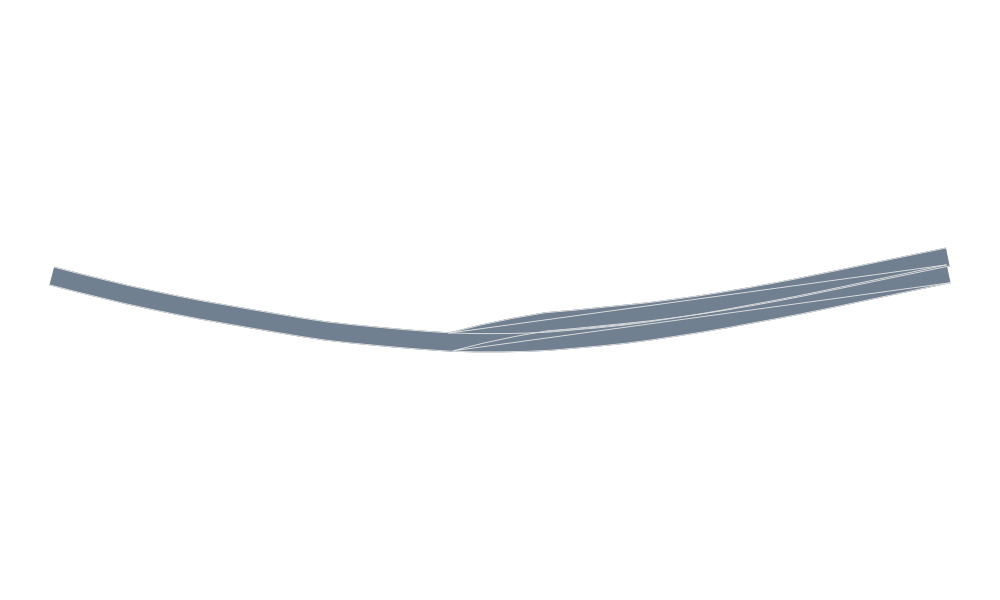

In [125]:
road_random = Roadway()
push!(road_random.segments,RoadSegment(1,[lane0]))
push!(road_random.segments,RoadSegment(2,[lane1]))
render(road_random)

In [127]:
run_a_vehicle(veh_id=29,roadway=road_random,filename="media/random.mp4",duration=10.)

Making video filename: media/random.mp4


In [123]:
merge_index = curveindex_end(track_a)

CurveIndex(379, 1.000)

In [ ]:
track_a = centerlines_txt2tracks_new("test_a.txt")
track_b = centerlines_txt2tracks_new("test_b.txt")
track_c = centerlines_txt2tracks_new("test_c.txt")
track_d = centerlines_txt2tracks_new("test_d.txt")
track_f = centerlines_txt2tracks_new("test_f.txt")
track_g = centerlines_txt2tracks_new("test_g.txt")
track_h = centerlines_txt2tracks_new("test_h.txt")
track_i = centerlines_txt2tracks_new("test_i.txt")

roadway_interaction = Roadway()
lane0 = Lane(LaneTag(1,1),track0)
lane1 = Lane(LaneTag(2,1),track1)
lane2 = Lane(LaneTag(3,1),track2)
lane3 = Lane(LaneTag(4,1),track3)
lane4 = Lane(LaneTag(5,1),track4)
lane5 = Lane(LaneTag(6,1),track5)
lane6 = Lane(LaneTag(7,1),track6)
push!(roadway_interaction.segments, RoadSegment(1, [lane0]))
push!(roadway_interaction.segments, RoadSegment(2, [lane1]))
push!(roadway_interaction.segments, RoadSegment(3, [lane2]))
push!(roadway_interaction.segments, RoadSegment(4, [lane3]))
push!(roadway_interaction.segments, RoadSegment(5, [lane4]))
push!(roadway_interaction.segments, RoadSegment(6, [lane5]))
push!(roadway_interaction.segments, RoadSegment(7, [lane6]))

return roadway_interaction
